In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy.linalg import LinAlgError
import seaborn as sns

random_seed = 42
np.random.seed(random_seed)

In [2]:
def moore_penrose_pseudoinv(X):
    return np.linalg.inv(X.T @ X) @ X.T


def W_alpha_task(X_s, X_q, alpha):
    assert (X_s.shape == X_q.shape)
    n = X_s.shape[0]
    p = X_s.shape[1]
    return (np.eye(p) - (alpha/n) * X_s.T @ X_q) @ X_q.T
    
    
def Z_alpha_task(X_s, y_s, X_q, y_q, alpha):
    assert (X_s.shape == X_q.shape)
    assert (y_s.shape == y_q.shape)
    n = X_s.shape[0]
    return y_q - (alpha/n) * X_q @ (X_s.T @ y_s)


def grad_task(X_s, y_s, theta):
    n = X_s.shape[0]
    return (1./n) * ((X_s.T @ X_s) @ theta - X_s.T @ y_s)


def adapt_task(X_s, y_s, theta, alpha):
    return theta - alpha * grad_task(X_s, y_s, theta)

In [3]:
def sample_task(n, p, X_s_fixed=None):
    # task param
    theta_t = np.random.uniform(0, 2, size=(p))
    sigma_t = np.random.uniform(0, np.sqrt(0.01))
    V_t = np.stack([np.random.normal(size=(p)) for _ in range(p)], axis=0).T
    V_t = np.linalg.qr(V_t)[0]
    Q_t = V_t @ np.diag(theta_t) @ V_t.T
    # support
    e_s = np.random.normal(size=(n)) * sigma_t
    if X_s_fixed is None:
        X_s = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    else:
        X_s = X_s_fixed
    y_s = X_s @ theta_t + e_s
    # query
    e_q = np.random.normal(size=(n)) * sigma_t
    X_q = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    y_q = X_q @ theta_t + e_q
    return X_s, y_s, X_q, y_q, theta_t


def evaluate_theta_over_multiple_tasks(theta_hat, alpha, n, X_s_fixed):
    p = len(theta_hat)
    M = 1000
    risk = []
    for _ in range(M):
        X_s, y_s, X_q, y_q, _ = sample_task(n, p, X_s_fixed)
        theta_hat_t = adapt_task(X_s, y_s, theta_hat, alpha)
        risk.append(np.mean((X_q @ theta_hat_t - y_q)**2))
    return np.mean(risk)

In [4]:
def main(n_runs, M, n, p, alpha):

    runs = []
    for _ in tqdm(range(n_runs)):
        # Single Run
        W_alpha = []
        Z_alpha = []
        # iterate over tasks
        for _ in range(M):
            X_s, y_s, X_q, y_q, _ = sample_task(n, p)
            W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
            Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
        W_alpha = np.concatenate(W_alpha, axis=0)
        Z_alpha = np.concatenate(Z_alpha, axis=0)
        argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
        runs.append(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))


    runs_drs = []
    for _ in tqdm(range(n_runs)):
        # Single Run
        W_alpha = []
        Z_alpha = []
        # iterate over tasks
        for _ in range(M):
            X_s, y_s, X_q, y_q, _ = sample_task(n, p)
            W_alpha.append(W_alpha_task(X_s, X_q, 0.).T)
            Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, 0.))
        W_alpha = np.concatenate(W_alpha, axis=0)
        Z_alpha = np.concatenate(Z_alpha, axis=0)
        argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
        runs_drs.append(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=0., n=n, X_s_fixed=None))



    runs_fixml = []
    for _ in tqdm(range(n_runs)):
        # Single FixML Run
        W_alpha = []
        Z_alpha = []
        # iterate over tasks
        X_s_fixed, _, _, _, _ = sample_task(n, p)
        for _ in range(M):
            X_s, y_s, X_q, y_q, _ = sample_task(n, p, X_s_fixed=X_s_fixed)
            W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
            Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
        W_alpha = np.concatenate(W_alpha, axis=0)
        Z_alpha = np.concatenate(Z_alpha, axis=0)
        argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
        runs_fixml.append(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))

    return runs, runs_drs, runs_fixml

  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=5 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=5 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=10 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=10 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=50 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=5 n=50 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=5 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=5 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=10 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=10 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=50 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=10 n=50 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=5 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=5 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=10 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=10 p=10 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=50 p=5 alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Running M=50 n=50 p=10 alpha=0.5


100%|██████████| 50/50 [13:54<00:00, 16.69s/it]


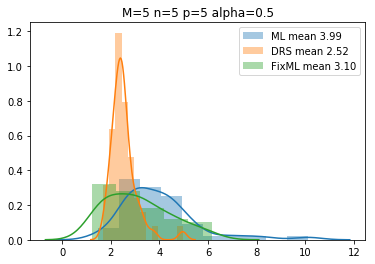

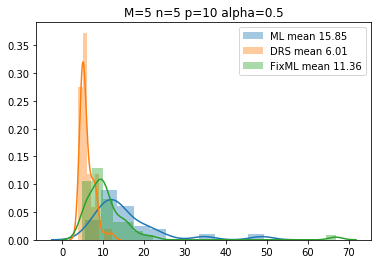

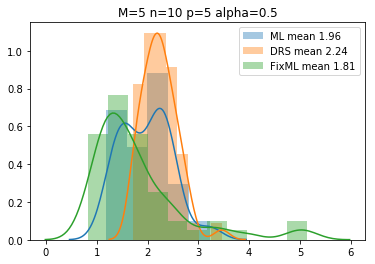

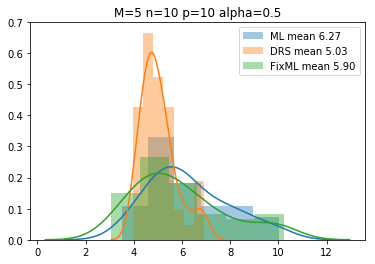

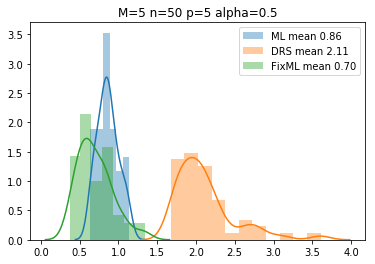

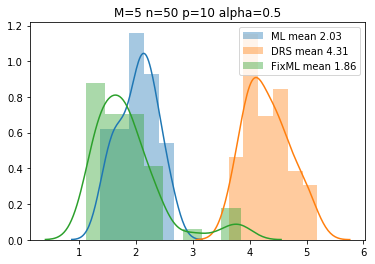

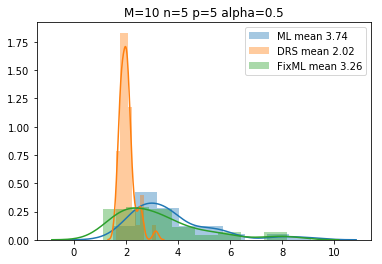

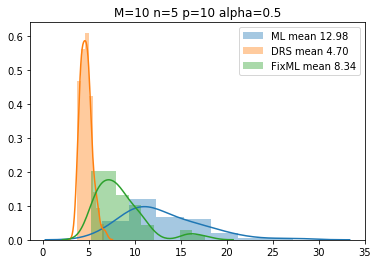

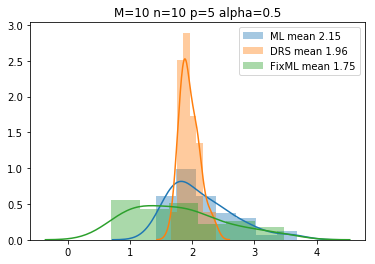

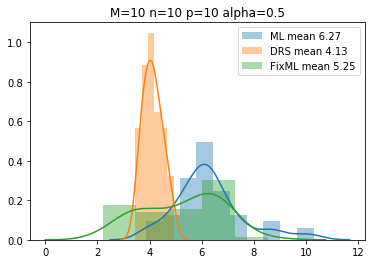

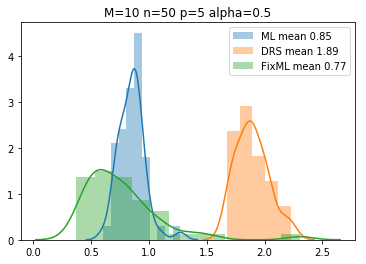

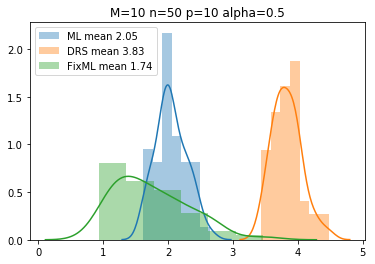

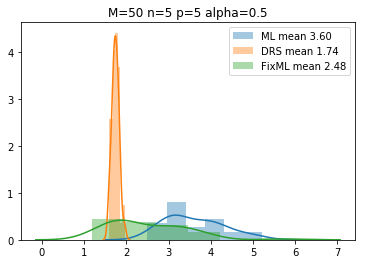

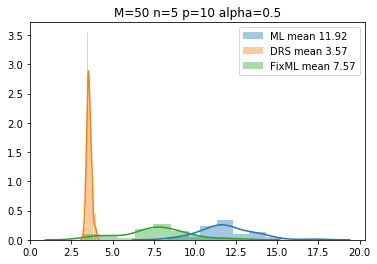

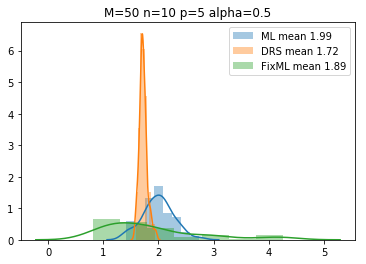

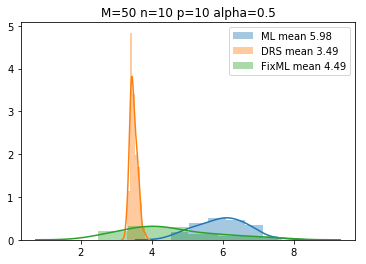

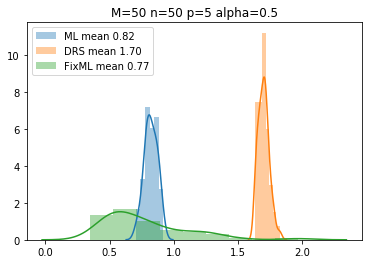

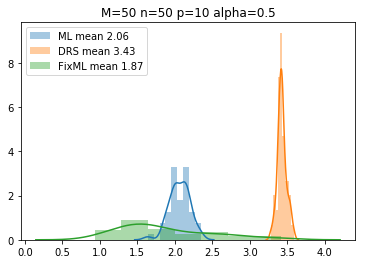

In [5]:
n_runs = 50
alpha = 0.5 # inner loop lr
# M is no. of tasks to sample
# n is no. of support/query samples in a task
# p is ambient dimension

for M in [5, 10, 50]:
    for n in [5, 10, 50]:
        for p in [5, 10]:
            print(f"Running M={M} n={n} p={p} alpha={alpha}")
            fig = plt.figure()
            runs, runs_drs, runs_fixml=main(M=M, n=n, p=p, alpha=alpha, n_runs=n_runs)
            sns.distplot(runs, label='ML mean %.2f' % np.mean(runs))
            sns.distplot(runs_drs, label='DRS mean %.2f' % np.mean(runs_drs))
            sns.distplot(runs_fixml, label='FixML mean %.2f' % np.mean(runs_fixml))
            plt.title(f"M={M} n={n} p={p} alpha={alpha}")
            plt.legend()
            plt.savefig(f"res_M={M}_n={n}_p={p}_alpha={alpha}_n_runs={n_runs}.png")